In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



2023-08-08 15:06:54.433221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load data
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
with open(os.path.join(full_folder_path,"Aug7_1mil.pkl"), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
print(len(clean_data_dict['2_phi']))

data_dict=deepcopy(clean_data_dict)
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])

dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [3]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'charge_2', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'charge_3', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'], 
    ['deltaphi_13', 'deltaeta_13', 'deltaR_13', 'mt_13', 'norm_mt_13'], 
    ['deltaphi_23', 'deltaeta_23', 'deltaR_23', 'mt_23', 'norm_mt_23']
]
labels = {}
for edge, features in zip(pair_order, used_labels2):
    labels[edge] = {feature: data_dict[feature] for feature in features if feature in data_dict}

input_data = {}
for particle, features in zip(input_data_particle_order, input_data_names_ordered):
    input_data[particle] = {feature: data_dict[feature] for feature in features if feature in data_dict}


In [4]:
scalers = {}

for particle, features in zip(input_data_particle_order, input_data_names_ordered):
    for feature in features:
        if feature in data_dict_np:
            scaler = StandardScaler()
            data = data_dict_np[feature].reshape(-1, 1)
            scaler.fit(data)
            data_dict_np[feature] = scaler.transform(data).flatten()
            scalers[(particle, feature)] = scaler

for edge, features in zip(pair_order, used_labels2):
    for feature in features:
        if feature in data_dict_np:
            scaler = StandardScaler()
            data = data_dict_np[feature].reshape(-1, 1)
            scaler.fit(data)
            data_dict_np[feature] = scaler.transform(data).flatten()
            scalers[(edge, feature)] = scaler

for particle, features in zip(input_data_particle_order, input_data_names_ordered):
    input_data[particle] = {feature: data_dict_np[feature] for feature in features if feature in data_dict_np}

for edge, features in zip(pair_order, used_labels2):
    labels[edge] = {feature: data_dict_np[feature] for feature in features if feature in data_dict_np}


In [5]:

lepton_labels=['1_2', '1_3', '2_3']
lepton_label_dict= {key: labels[key] for key in lepton_labels}

input_leptons=['1', '2', '3']
input_lepton_dict = {key: input_data[key] for key in input_leptons}

print(lepton_label_dict.keys())
print(lepton_label_dict['1_2'].keys())
print(input_lepton_dict.keys())
print(input_lepton_dict['1'].keys())
print(len(input_lepton_dict['1']['pt_1']))

dict_keys(['1_2', '1_3', '2_3'])
dict_keys(['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'])
dict_keys(['1', '2', '3'])
dict_keys(['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'])
568554


In [6]:
i_3d_1=list(input_lepton_dict.keys())
i_3d_2=list(input_lepton_dict[i_3d_1[0]].keys())

shape = (len(i_3d_1),len(i_3d_2), len(input_lepton_dict[i_3d_1[0]][i_3d_2[0]]))
input_lepton_3d=np.empty(shape, dtype=float)

for i, k1 in enumerate(i_3d_1):
    for j, k2 in enumerate(i_3d_2):
        
        currfeat=input_data_names_ordered[1+i][j]
        
        input_lepton_3d[i,j,:]=input_lepton_dict[k1][currfeat]

print("input shape: ", input_lepton_3d.shape)
numevents=len(lepton_label_dict['1_2']['deltaphi_12'])

o_3d_1=list(lepton_label_dict.keys())
shape_output=(len(o_3d_1),len(lepton_label_dict[o_3d_1[0]]),numevents)
output_lepton_3d=np.empty(shape_output, dtype=float)
for i in range(len(o_3d_1)):
    for j in range(len(lepton_label_dict[o_3d_1[i]])):
        currfeat=used_labels2[i+3][j]
        # print(o_3d_1[i], currfeat)
        output_lepton_3d[i,j,:]=lepton_label_dict[o_3d_1[i]][currfeat]

print("output shape: ", output_lepton_3d.shape)

tf_input_lepton_3d = tf.convert_to_tensor(input_lepton_3d, dtype=tf.float32)
tf_output_lepton_3d = tf.convert_to_tensor(output_lepton_3d, dtype=tf.float32)       

split_index = int(0.8 * tf_input_lepton_3d.shape[2])

train_inputs = tf_input_lepton_3d[:, :, :split_index]
test_inputs = tf_input_lepton_3d[:, :, split_index:]

train_outputs = tf_output_lepton_3d[:, :, :split_index]
test_outputs = tf_output_lepton_3d[:, :, split_index:]


print("train_inputs shape: ", train_inputs.shape)
print("test_inputs shape: ", test_inputs.shape)

train_inputs_reshaped = np.transpose(train_inputs, (2, 0, 1))
test_inputs_reshaped = np.transpose(test_inputs, (2, 0, 1))
train_outputs_reshaped = np.transpose(train_outputs, (2, 0, 1))
test_outputs_reshaped = np.transpose(test_outputs, (2, 0, 1))



input shape:  (3, 5, 568554)
output shape:  (3, 5, 568554)
train_inputs shape:  (3, 5, 454843)
test_inputs shape:  (3, 5, 113711)


2023-08-08 15:07:16.875194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:


input_shape = input_lepton_3d.shape


model = models.Sequential()

model.add(layers.Input(shape=input_shape[:2]))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(80, activation='relu'))

model.add(layers.Dense(64, activation='relu'))


model.add(layers.Dense((output_lepton_3d.shape)[1], activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 64)             384       
                                                                 
 dense_1 (Dense)             (None, 3, 128)            8320      
                                                                 
 dense_2 (Dense)             (None, 3, 80)             10320     
                                                                 
 dense_3 (Dense)             (None, 3, 64)             5184      
                                                                 
 dense_4 (Dense)             (None, 3, 5)              325       
                                                                 
Total params: 24,533
Trainable params: 24,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_inputs_reshaped, train_outputs_reshaped, epochs=10, batch_size=32, validation_data=(test_inputs_reshaped, test_outputs_reshaped))
loss = model.evaluate(test_inputs_reshaped, test_outputs_reshaped)
print("Test loss:", loss)


Epoch 1/10
14214/14214 [==============================] - 89s 6ms/step - loss: 0.9603 - val_loss: 0.9607
Epoch 2/10
14214/14214 [==============================] - 52s 4ms/step - loss: 0.9595 - val_loss: 0.9604
Epoch 3/10
14214/14214 [==============================] - 51s 4ms/step - loss: 0.9594 - val_loss: 0.9606
Epoch 4/10
14214/14214 [==============================] - 47s 3ms/step - loss: 0.9593 - val_loss: 0.9604
Epoch 5/10
14214/14214 [==============================] - 48s 3ms/step - loss: 0.9592 - val_loss: 0.9606
Epoch 6/10
14214/14214 [==============================] - 44s 3ms/step - loss: 0.9591 - val_loss: 0.9603
Epoch 7/10
14214/14214 [==============================] - 44s 3ms/step - loss: 0.9591 - val_loss: 0.9605
Epoch 8/10
14214/14214 [==============================] - 54s 4ms/step - loss: 0.9591 - val_loss: 0.9602
Epoch 9/10
14214/14214 [==============================] - 51s 4ms/step - loss: 0.9591 - val_loss: 0.9603
Epoch 10/10
3554/3554 [==============================] 

In [9]:
predictions = model.predict(test_inputs_reshaped)
residuals = test_outputs_reshaped - predictions

3554/3554 [==============================] - 7s 2ms/step


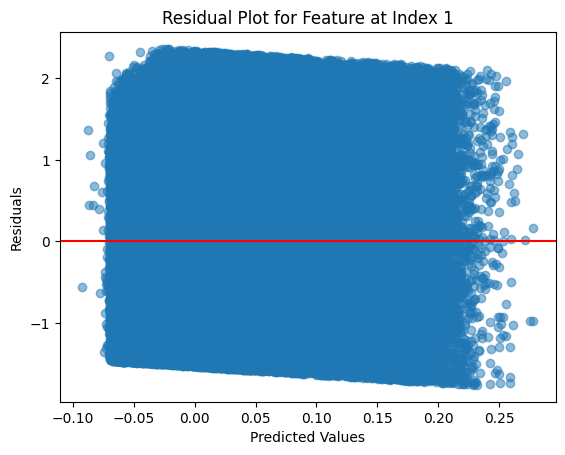

In [10]:


feature_idx = 1

plt.scatter(predictions[:, 0, feature_idx], residuals[:, 0, feature_idx], alpha=0.5)
plt.title('Residual Plot for Feature at Index ' + str(feature_idx))
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')  
plt.show()
